# Predicting Neurodegenerative Disease: Parkinson's disease (PD)

Data Set Information:

This dataset is composed of a range of biomedical voice measurements from 
31 people, 23 with Parkinson's disease (PD). Each column in the table is a 
particular voice measure, and each row corresponds one of 195 voice 
recording from these individuals ("name" column). The main aim of the data 
is to discriminate healthy people from those with PD, according to "status" 
column which is set to 0 for healthy and 1 for PD.

Attribute Information:

Matrix column entries (attributes):
name - ASCII subject name and recording number

MDVP:Fo(Hz) - Average vocal fundamental frequency

MDVP:Fhi(Hz) - Maximum vocal fundamental frequency

MDVP:Flo(Hz) - Minimum vocal fundamental frequency

MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several 

measures of variation in fundamental frequency

MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude

NHR,HNR - Two measures of ratio of noise to tonal components in the voice

status - Health status of the subject (one) - Parkinson's, (zero) - healthy

RPDE,D2 - Two nonlinear dynamical complexity measures

DFA - Signal fractal scaling exponent

spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 




In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


PD_data=pd.read_csv('parkinsons (1).data')
PD_data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [65]:
PD_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

No null values in the dataset,
columns are in the correct data type apart from the target column ('status') that can be represented as a categorical variable
so it's considerably clean

In [66]:
y=PD_data['status']
X=PD_data.drop(['name','status'], axis=1)

Text(0.5, 0, '')

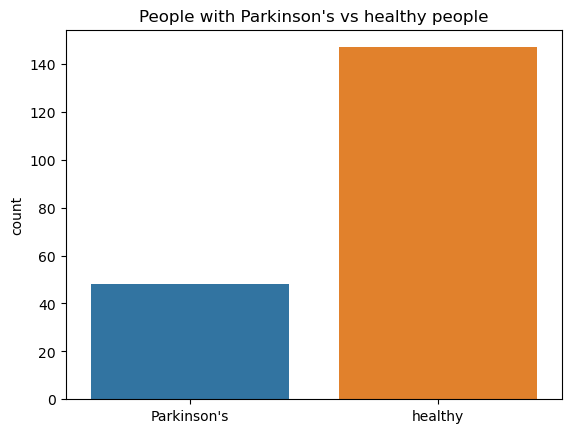

In [67]:
#visualizing the ratio of people with parkinson's disease to those without
sns.countplot(x='status',data=PD_data)
plt.title("People with Parkinson's vs healthy people")
plt.xticks(ticks=[0,1],labels=["Parkinson's",'healthy'])
plt.xlabel('')


We have 24 columns which is considerable a lot compared to the rows (195) so dimensionality reduction is needed.

In [68]:
thresholder = VarianceThreshold(threshold=.04)
thresholder.fit(X)

VarianceThreshold(threshold=0.04)

<AxesSubplot:>

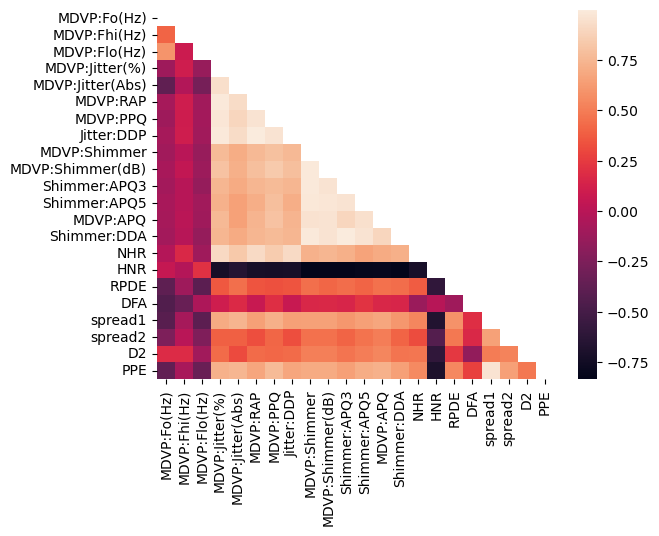

In [69]:
#Visualizing correlation to see if we can use it in dimensionality reduction
corr_df =  X.corr(method='pearson')
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut)

In [70]:
upper_tri = corr_df.abs().where(mask_ut)
to_drop = [column for column in upper_tri.columns if any((upper_tri[column] > 0.95) & (upper_tri[column] != 1))]
print(to_drop)
X = X.drop(to_drop, axis=1)

['MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'PPE']


In [75]:
X.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2'],
      dtype='object')

In [71]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,stratify=y)
#Drop columns with zero variance if any
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [72]:
#model building
clf = RandomForestClassifier(n_estimators = 100, random_state=42) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### choice of metric
I will be using the recall metric to score the model so I can minimize false negatives. i.e. not miss out on so many people with PD

In [73]:
print('recall_score is ',sklearn.metrics.recall_score(y_test, y_pred))

recall_score is  0.9772727272727273


In [74]:
print('accuracy_score is ',sklearn.metrics.accuracy_score(y_test, y_pred))
print('precision_score is ',sklearn.metrics.precision_score(y_test, y_pred))
print('f1_score is ',sklearn.metrics.f1_score(y_test, y_pred))


accuracy_score is  0.9322033898305084
precision_score is  0.9347826086956522
f1_score is  0.9555555555555557


<bound method BaseEstimator._check_feature_names of RandomForestClassifier(random_state=42)>

Text(0.5, 0, 'Random Forest Feature Importance')

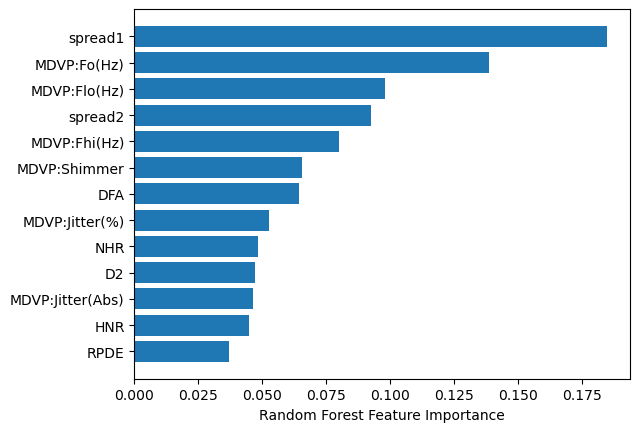

In [79]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Reference

'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 
Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. 
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)

Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 
'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', 
IEEE Transactions on Biomedical Engineering (to appear)
